### ДЗ к уроку 8. Кейс 2. Типы моделей для задачи оттока

#### Предобработка данных

In [26]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [2]:
# Загрузим набор данных

df = pd.read_csv('freMPL-R.csv', low_memory=False)
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [3]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0
df.Gender, GenderRef = SeriesFactorizer(df.Gender)
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])
df = df.select_dtypes(exclude=['object'])
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

{0: 'Male', 1: 'Female'}
{0: 'Other', 1: 'Alone'}


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 24 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Exposure                         115155 non-null  float64
 1   LicAge                           115155 non-null  int64  
 2   Gender                           115155 non-null  int64  
 3   MariStat                         115155 non-null  int64  
 4   DrivAge                          115155 non-null  int64  
 5   HasKmLimit                       115155 non-null  int64  
 6   BonusMalus                       115155 non-null  int64  
 7   ClaimAmount                      115155 non-null  float64
 8   ClaimInd                         115155 non-null  int64  
 9   OutUseNb                         115155 non-null  float64
 10  RiskArea                         115155 non-null  float64
 11  VehUsage_Private                 115155 non-null  uint8  
 12  Ve

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Заменим значение 11 на 10.

In [5]:
df.loc[df['ClaimsCount'] == 11, 'ClaimsCount'] = 10
df['ClaimsCount'].value_counts()

0.0     104286
2.0       3529
1.0       3339
3.0       2310
4.0       1101
5.0        428
6.0        127
7.0         26
8.0          6
9.0          2
10.0         1
Name: ClaimsCount, dtype: int64

Посмотрим, сколько полисов соответствуют каждому из значений ClaimsCount, используя метод groupby. Для полученных значений также посчитаем нормированную частоту.

In [6]:
df['ClaimsCount'].value_counts()

0.0     104286
2.0       3529
1.0       3339
3.0       2310
4.0       1101
5.0        428
6.0        127
7.0         26
8.0          6
9.0          2
10.0         1
Name: ClaimsCount, dtype: int64

In [7]:
FreqCount = pd.DataFrame(df['ClaimsCount'].value_counts())
FreqCount['Freq'] = FreqCount['ClaimsCount'] / FreqCount['ClaimsCount'].sum()

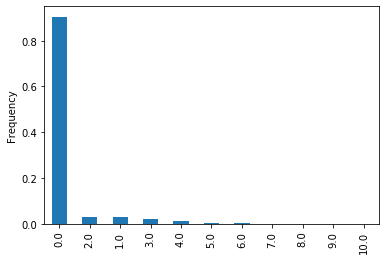

In [8]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [9]:
FreqCount

,ClaimsCount,Freq
0.0,104286,0.905614
2.0,3529,0.030646
1.0,3339,0.028996
3.0,2310,0.020060
4.0,1101,0.009561
5.0,428,0.003717
6.0,127,0.001103
7.0,26,0.000226
8.0,6,0.000052
9.0,2,0.000017


Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.05` для значений `ClaimsCount` 0, а для остальных - 1 (Для этого можем использовать функцию `np.where`). Также можно попробовать какой-либо другой способ задания весов, приведенный пример не гарантирует хороших результатов.

In [10]:
df['weight'] = np.where(df['ClaimsCount'] < 1, 0.05, 1)

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount'], axis=1), 
                                                    df['ClaimsCount'], test_size=0.3, random_state=10)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

Далее, создадим объекты DMatrix для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр weight равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр data.

In [12]:
xgb_train = xgb.DMatrix(x_train.drop(columns=['weight']).values, y_train.values, weight=x_train['weight'].values)
xgb_valid = xgb.DMatrix(x_valid.drop(columns=['weight']).values, y_valid.values)
xgb_test = xgb.DMatrix(x_test.drop(columns=['weight']).values, y_test.values)

#### Для оптимизации гиперпараметров можно воспользоваться различными методами.

Будем использовать мультиклассовую log_loss метрику.

In [13]:
n_classes = 11

In [14]:
# Зададим функцию Deviance для распределения Пуассона

def xgb_eval_dev_poisson(yhat, y):
    """
    Function for Poisson Deviance evaluation
    :param yhat: np.ndarray object with predictions
    :param y: xgb.DMatrix object with target variable
    :return: (str, float), tuple with metrics name and its value
    """
    t_hat, t = yhat + 1, y.get_label() + 1
    return 'dev_poisson', 2 * np.sum(t * np.log(t / t_hat) - (t - t_hat))

In [15]:
# Определим функцию для оптимизации гиперпараметров алгоритмом TPE

def objective(params):
    """
    Objective function for hyperopt. Optimizing mean cross-validation error with XGBoost.

    :param params: dict object passed to hyperopt fmin() function
    :return: float, mean cross-validation error for XGBoost utilizing params
    """
    params['max_depth'] = int(params['max_depth'])
    n_b_r = int(params.pop('num_boost_round'))
    data = params.pop('data')
#     feval = params.pop('feval')
    nfold = params.pop('nfold')
    e_s_r = params.pop('early_stopping_rounds')
    maximize = params.pop('maximize')
    cv_result = xgb.cv(params, data, num_boost_round=n_b_r, nfold=nfold, seed=10, maximize=maximize,
                       early_stopping_rounds=e_s_r)
#     name, _ = feval(data.get_label(), data)
    score = cv_result['test-mlogloss-mean'][-1:].values[0]
    return score

In [16]:
# Определим границы, в которых будем искать гиперпараметры

space_freq = {
    'data': xgb_train,
    'objective': 'multi:softmax',
    'num_class': n_classes,
    'eval_metric': 'mlogloss',
    'maximize': False,
    'nfold': 5,
    'early_stopping_rounds': 20,
    'num_boost_round': 300,  # hp.choice('num_boost_round', [50, 300, 500])
    'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
    'min_child_weight': hp.uniform('min_child_weight', 0, 50),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'alpha': hp.uniform('alpha', 0, 1),
    'lambda': hp.uniform('lambda', 0, 1),
    'eta': hp.uniform('eta', 0.01, 1),
}

In [17]:
# Оптимизация (количество итераций снижено для ускорения работы)

best = fmin(fn=objective, space=space_freq, algo=tpe.suggest, max_evals=10)

100%|████████████████████████████████████████████████████████| 10/10 [29:37<00:00, 177.73s/trial, best loss: 1.5624962]


In [18]:
# Оптимальные гиперпараметры 

best_params = space_eval(space_freq, best)
best_params

{'alpha': 0.4034024838240041,
 'colsample_bytree': 0.8825584807403373,
 'data': <xgboost.core.DMatrix at 0x244d7bcad48>,
 'early_stopping_rounds': 20,
 'eta': 0.03842577183432461,
 'eval_metric': 'mlogloss',
 'lambda': 0.5066980192478866,
 'max_depth': 5,
 'maximize': False,
 'min_child_weight': 46.108937719482135,
 'nfold': 5,
 'num_boost_round': 300,
 'num_class': 11,
 'objective': 'multi:softmax',
 'subsample': 0.785471674926862}

Далее обучим нашу модель с оптимальными параметрами

In [19]:
def train_xgb_best_params(params, dtrain, evals, early_stopping_rounds, evals_result=None, verbose_eval=None):
    """
    Function to train XGBoost estimator from set of parameters, passed from hyperopt.

    :param params: dict, hyperparameters from hyperopt space_eval() function
    :param dtrain: xgb.DMatrix object, to train model on
    :param evals: list of pairs (DMatrix, str). Same from xgb.train().
    :param early_stopping_rounds: int. Same from xgb.train().
    :param evals_result: dict. Same from xgb.train().
    :param verbose_eval: bool or int. Same from xgb.train().
    :return: xgb.Booster object, trained model
    """
    par = params.copy()
    for label in ['nfold', 'data', 'early_stopping_rounds']:
        del par[label]
    n_b_r = int(par.pop('num_boost_round'))
    maximize = par.pop('maximize')
#     feval = par.pop('feval')
    return xgb.train(params=par, dtrain=dtrain, num_boost_round=n_b_r, evals=evals, maximize=maximize,
                     early_stopping_rounds=early_stopping_rounds, evals_result=evals_result, verbose_eval=verbose_eval)


In [20]:
# Построение модели с ранней остановкой (early stopping)

progress = dict()
xgb_freq = train_xgb_best_params(best_params, xgb_train, [(xgb_train, "train"),(xgb_train, "valid")], early_stopping_rounds=10, evals_result=progress, verbose_eval=False)

Посчитаем метрику f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью plt.imshow(). Можно использовать предложенный ниже код.

In [21]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    class_preds = xgb_freq.predict(dfset['dmat']) # Посчитаем предсказанные значения
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds, average='micro')) # Посчитаем F1 Score

F1 Score on train: 0.664363338626439
F1 Score on valid: 0.6558791176981416
F1 Score on test: 0.6563042723167767


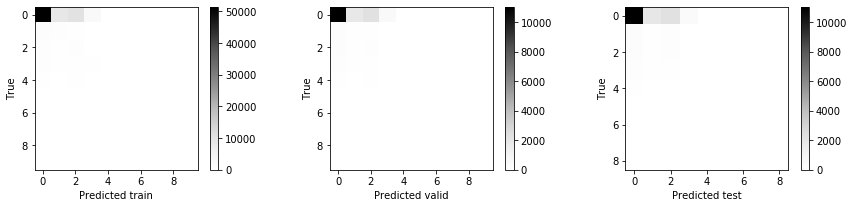

In [25]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb_freq.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted '+ str(dfsets[i]['set']))
plt.show()

#### Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

Качество модели - слабое. Наверное, проблема - дисбаланс классов. Дисбаланс классов можно уменьшить oversampling-ом.